# Port Congestion Machine Learning
This notebook contains all the code and brief explanation of modelling a port congestion simulation using machine learning and synthetic data.

For a more in depth explanation of this notebook's rationale and assumptions, please refer to the documentation.

## Executive summary
In order to simulate a realistic port congestion conditions, we will factor in 3 things: **Market factor**, **weather factor**, and **operational factor**:

1. **Market factor**: BDI (Baltic Dry Index) will be used as proxy for fleet utilization, which will be use for calculating the actual delay days.
2. **Weather factor**: Modeled as deterministic physics, where weather affects safety regulations and machinery limitations, acting as "kill switch" of the port operations.
3. **Operational factor**: Chaos layer, representing unpredictable human errors, equipment issues, channel blockage, etc, that is implemented as "Black Swans"- a rare, but major/catastrophic effect.

Synthetic data will be generate according to these 3 factors + injected error/uncertainties, followed by training an ML model to capture these syntheticaly realistic congestion pattern.



## Before running this notebook:
* Make sure to have `bdi_clean.csv` file under /data.
* If not, please run `bdi_cleaning.py` (make sure `bdi_raw.csv` exists inside /data).

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xgboost as xgb
import joblib
from sklearn.metrics import mean_absolute_error, r2_score

# Set project root path ONCE for all cells
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

## Methodology

### 1. Market Factor

To simulate congestion, we will be using **Baltic Dry Index (BDI)** as the proxy to represent global shipping demand. BDI itself is the standard economic indicator issued daily by the Baltic Exchange in London.

*Assumption*
* High BDI (Baltic Dry Index) values are a direct mathematical proxy for High Fleet Utilization.
* When the fleet is fully utilized, port queues form naturally due to the "Arrival Rate" exceeding the "Service Rate" (Queueing Theory).

*Justification*
* > "BDI index experiences high levels of volatility if global demand increases or suddenly drops off because the supply of large carriers tends to be small with long lead times and high production costs."
[Reference Link](https://www.investopedia.com/terms/b/baltic_dry_index.asp) 

  Explanation: production of vessel and carrier processes tends to be slow/small, thus when high demand surges, BDI shoots up (inelastic supply constraint). Thus we associate high BDI value with high demand surge, thus higher fleet utilization.

* > "0% increase in freight rates correlates with a 1.3% increase in fleet productivity (utilization)."
 [Reference Link](https://www.researchgate.net/publication/358333409_The_Effect_of_Freight_Rates_on_Fleet_Productivity_An_Empirical_Research_on_Dry_Bulk_Market)

  Explanation: BDI is standard indicator for prices of dry bulk shipping (freight rates), and based on this research’s model, it correlates with 1.3% increase in productivity, in other words utilization.





#### **Translating BDI proxy into actual delays**



We grounded our model in **Queueing Theory**, specifically the behavior of limited-resource systems under high load.

##### **Kingsman's Approximation**
In maritime logistics, a port acts as a G/G/1 queueing system. The fundamental law governing delay in such systems is **Kingman’s Approximation**:

$W_q \approx \left( \frac{\rho}{1 - \rho} \right) \cdot \left( \frac{C_a^2 + C_s^2}{2} \right) \cdot \tau$ ,  where $\rho$ is utilization rate

Which shows the asymptotic behavior (infinite delay) as utilization nears 100%.

However, this formula introduces **significant instability**, and produces unrealistic delay values in scenario of **high congestion**. Furthermore, real-world systems have "relief valves" (ships divert, speed up, or cancel) that prevent literally infinite delays.

Thus, we opt for a parabolic function (polynomial proxy):

$D_{mkt} \propto ( \frac{\text{BDI}}{\text{constant}} )^2$




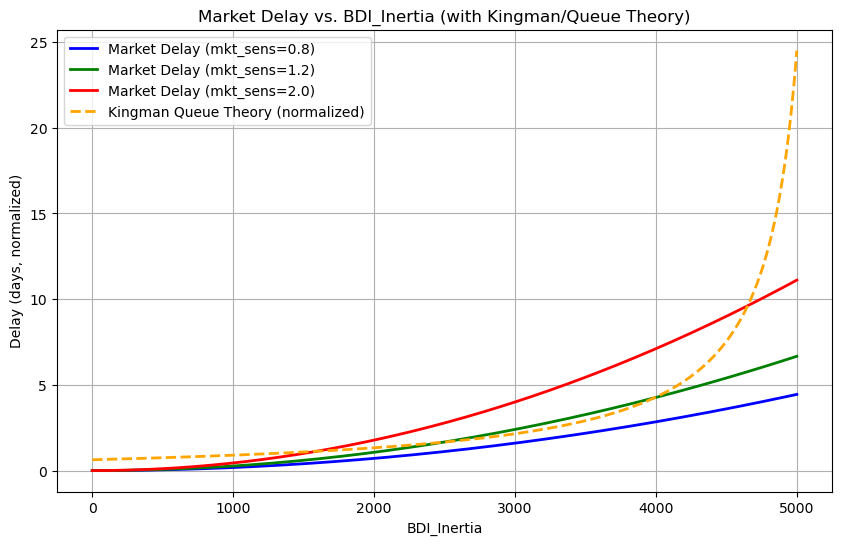

In [47]:

# Parameters
mkt_sens_list = [0.8, 1.2, 2.0]
colors = ['blue', 'green', 'red']

# Generate BDI values
bdi_values = np.linspace(0, 5000, 500)

plt.figure(figsize=(10, 6))

# Plot market delay curves for each sensitivity
for mkt_sens, color in zip(mkt_sens_list, colors):
    mkt_stress = (bdi_values / 1500.0) ** 2.0
    delay_mkt = np.minimum(30.0, mkt_stress * mkt_sens * 0.5)
    plt.plot(bdi_values, delay_mkt, label=f'Market Delay (mkt_sens={mkt_sens})', color=color, linewidth=2)

# Kingman/Queue Theory Curve
rho = 0.60 + (0.38 * (bdi_values - 500) / 4500)
rho = np.clip(rho, 0, 0.98)  # Avoid division by zero
kingman_y = (rho / (1 - rho))
kingman_y = kingman_y * 0.5  # Normalize for visual comparison
plt.plot(bdi_values, kingman_y, label='Kingman Queue Theory (normalized)', linestyle='--', color='orange', linewidth=2)

plt.xlabel('BDI_Inertia')
plt.ylabel('Delay (days, normalized)')
plt.title('Market Delay vs. BDI_Inertia (with Kingman/Queue Theory)')
plt.grid(True)
plt.legend()
plt.show()


##### **Hysteresis Effect**

For the BDI input, using the daily Baltic Dry Index (BDI) would be physically incorrect due to the "Snappiness Fallacy"—financial **prices change instantly**, but **physical ship queues do not**. 

Thus, we implemented System Hysteresis by feeding the function a 45-Day Rolling Inertia (BDI_Inertia) rather than the Spot Price.

This effectively **filters noises** in BDI though, causing us to assume the effect of solely the general long term pattern of BDI rather than the volatility, for the sake of simplicity.


Thus we end up with the following function:

In [48]:
def calculate_market_delay(bdi_inertia, sensitivity):
    """
    Calculates delay based on Market Saturation (Queueing Theory).
    Formula: Delay ~ (Inertia / 1500)^2 * Sensitivity
    """
    # 1. Calculate Market Stress (The "Hockey Stick" Curve)
    market_stress = (bdi_inertia / 1500.0) ** 2.0
    
    # 2. Apply Port Sensitivity (Hubs choke faster than small ports)
    raw_delay = market_stress * sensitivity * 0.5
    
    # 3. Apply Saturation Cap (Reality Check)
    return min(30.0, raw_delay)


### 2. Weather Factor
Unlike the Market Layer, which is **stochastic (probabilistic)**, the Weather Layer is modeled as **Deterministic Physics**. 

We assume that port operations do not "slow down" linearly with weather; they operate on a Binary Switch based on safety regulations and machinery limitations. We essentially encoded several “kill switches” based on international maritime standard.

*Assumptions*
* **IMSBC Code**: Loading stops if Rain > 20mm (Liquefaction Risk).
* **ZPMC Specs**: Cranes stop if Wind > 25m/s (Stability Risk).
* **MSA Rules**: Pilotage stops if Fog Risk > 0.8 (Visibility < 1000m).



In [49]:
def calculate_weather_delay(rain, wind, is_fog, config):
    """
    Calculates delay based on Physical Constraints (IMSBC, ZPMC, MSA).
    """
    # RAIN (IMSBC Code - Liquefaction Risk) 
    # Rain slows loading linearly, then stops it completely at >20mm
    raw_rain_delay = (rain / 20.0) * config['rain_sens']
    delay_rain = min(15.0, raw_rain_delay) # Cap: Ops find windows between showers
    
    # B. WIND (ZPMC Specs - Crane Stability) 
    # Cranes are pinned down at 25m/s.
    if wind > 35: 
        raw_wind = 1.0 * config['wind_sens'] # Total stoppage
    elif wind > 25: 
        raw_wind = 0.3 * config['wind_sens'] # Slow steam / Partial
    else: 
        raw_wind = 0.0
    delay_wind = min(7.0, raw_wind) # Cap: Storms rarely last >7 days
        
    # C. FOG (MSA Rules - Pilotage) 
    # Fog causes "Tidal Misses" (Wait 12 hours for next tide)
    raw_fog = 1.5 * config['fog_sens'] if is_fog else 0.0
    delay_fog = min(5.0, raw_fog) # Cap: Fog usually lifts by noon
    
    return delay_rain + delay_wind + delay_fog

### 3. Operational Factor

To prevent the model from being **overly deterministic**, we introduce Operational Entropy. 

We model this using a Gamma Distribution (Right-Skewed), which accounts for **routine friction** (shift changes) as well as rare **'Black Swan'** events (strikes, machinery collapse).

In [50]:
import numpy as np
import random

def calculate_operational_delay():
    """
    Calculates Stochastic Friction (Entropy).
    Uses Gamma Distribution to simulate "Fat Tail" risks (Black Swans).
    """
    # 1. Routine Friction (Shift changes, minor breakdowns)
    routine_friction = np.random.gamma(shape=1.5, scale=0.5)
    
    # 2. Black Swan Event (The "Chaos" Factor)
    # 0.5% chance of a major incident (Strike, Collision) adding 5-10 days
    is_black_swan = random.random() < 0.005
    black_swan_impact = random.uniform(5.0, 10.0) if is_black_swan else 0.0
    
    return routine_friction + black_swan_impact

## Data Generation

Now we will proceed with the data generation.

Note that we will be using real BDI data (2020 - 2025), however we will be using custom port configuration and climate settings for each ports.

### Port Configurations

Real-world ports are not equally affected by the same disruptions. A port handling moisture-sensitive Iron Ore fines in the tropics faces different physical constraints than a container terminal in a windy river delta.

To capture this, we assigned each of the 20+ ports a Sensitivity Coefficient Vector ($S$). These coefficients act as multipliers in our delay functions, scaling the impact of weather and market stress based on local infrastructure and cargo types.

We classified ports into "Risk Archetypes" to enforce realistic behavior:

* The "Liquefaction" Cluster (Brazil: Ponta da Madeira, Tubarao)

> Logic: These ports export Iron Ore Fines. Moisture control is critical to prevent cargo liquefaction (capsizing risk). Even moderate rain triggers a full work stoppage.

* The "Cyclone" Cluster (Australia: Port Hedland, Dampier)

> Logic: Located in "Cyclone Alley." While resistant to rain (conveyor belts), operations are frequently suspended due to high wind shear affecting ship loaders and tug safety.

* The "Fog & Draft" Cluster (Yangtze River: Zhangjiagang, Nantong)

> Logic: River ports require complex pilotage. Fog creates a binary "Shut Down" condition because vessels cannot navigate the narrow channel safely, leading to missed tides (12-hour delays).

* The "Congestion" Cluster (Major Hubs: Qingdao, Ningbo)

> Logic: These are the world's busiest ports. They have zero spare capacity. A 10% increase in global fleet arrivals (Bull Market) causes a disproportionate traffic jam compared to a smaller, less utilized port.

In [51]:
# ==============================================================================
# 1. PORT PHYSICS ENGINE (CONFIGURATION)
# ==============================================================================
# SENSITIVITY LEGEND:
# - Rain: High (2.0) for Liquefaction Risk (Loading) or Monsoon (Discharge).
# - Wind: High (2.0) for Exposed Cranes (Australia/SA).
# - Fog:  High (2.0) for Navigation Safety (River/North China).
# - Mkt:  High (2.0) for Major Hubs (Queueing Theory/Congestion).

PORT_CONFIG = {
    # --- ORIGIN: BRAZIL (The "Liquefaction" Cluster) ---
    'PONTA DA MADEIRA': {'type': 'Load', 'rain_sens': 2.0, 'wind_sens': 0.5, 'fog_sens': 0.1, 'mkt_sens': 1.2},
    'TUBARAO':          {'type': 'Load', 'rain_sens': 1.8, 'wind_sens': 0.5, 'fog_sens': 0.2, 'mkt_sens': 1.0},
    'ITAGUAI':          {'type': 'Load', 'rain_sens': 1.8, 'wind_sens': 0.5, 'fog_sens': 0.2, 'mkt_sens': 1.0},

    # --- ORIGIN: AUSTRALIA (The "Cyclone" Cluster) ---
    'PORT HEDLAND':     {'type': 'Load', 'rain_sens': 0.2, 'wind_sens': 2.0, 'fog_sens': 0.0, 'mkt_sens': 1.5},
    'DAMPIER':          {'type': 'Load', 'rain_sens': 0.2, 'wind_sens': 2.0, 'fog_sens': 0.0, 'mkt_sens': 1.2},

    # --- ORIGIN: GLOBAL OTHERS ---
    'SALDANHA BAY':     {'type': 'Load', 'rain_sens': 0.3, 'wind_sens': 1.8, 'fog_sens': 0.5, 'mkt_sens': 1.0}, # SA
    'TABONEO':          {'type': 'Load', 'rain_sens': 2.5, 'wind_sens': 1.5, 'fog_sens': 0.5, 'mkt_sens': 0.8}, # Indo
    'KAMSAR':           {'type': 'Load', 'rain_sens': 2.0, 'wind_sens': 1.0, 'fog_sens': 0.5, 'mkt_sens': 0.8}, # Guinea
    'VANCOUVER':        {'type': 'Load', 'rain_sens': 1.2, 'wind_sens': 0.8, 'fog_sens': 0.5, 'mkt_sens': 1.0}, # Canada

    # --- DESTINATION: YANGTZE RIVER (The "Fog & Draft" Cluster) ---
    'ZHANGJIAGANG':     {'type': 'Disch', 'rain_sens': 0.5, 'fog_sens': 2.0, 'wind_sens': 0.5, 'mkt_sens': 1.8},
    'NANTONG':          {'type': 'Disch', 'rain_sens': 0.5, 'fog_sens': 2.0, 'wind_sens': 0.5, 'mkt_sens': 1.6},
    'NANJING':          {'type': 'Disch', 'rain_sens': 0.5, 'fog_sens': 2.0, 'wind_sens': 0.5, 'mkt_sens': 1.5},
    'JIANGYIN':         {'type': 'Disch', 'rain_sens': 0.5, 'fog_sens': 2.0, 'wind_sens': 0.5, 'mkt_sens': 1.6},

    # --- DESTINATION: NORTH CHINA (The "Bohai Ice/Fog" Cluster) ---
    'CAOFEIDIAN':       {'type': 'Disch', 'rain_sens': 0.1, 'fog_sens': 2.0, 'wind_sens': 1.0, 'mkt_sens': 1.8},
    'TIANJIN':          {'type': 'Disch', 'rain_sens': 0.1, 'fog_sens': 2.0, 'wind_sens': 1.0, 'mkt_sens': 1.6},
    'JINGTANG':         {'type': 'Disch', 'rain_sens': 0.1, 'fog_sens': 2.0, 'wind_sens': 1.0, 'mkt_sens': 1.8},
    'QINHUANGDAO':      {'type': 'Disch', 'rain_sens': 0.1, 'fog_sens': 1.8, 'wind_sens': 1.0, 'mkt_sens': 1.5},
    'DALIAN':           {'type': 'Disch', 'rain_sens': 0.1, 'fog_sens': 1.8, 'wind_sens': 1.2, 'mkt_sens': 1.5},
    'YINGKOU':          {'type': 'Disch', 'rain_sens': 0.1, 'fog_sens': 2.0, 'wind_sens': 1.2, 'mkt_sens': 1.5},

    # --- DESTINATION: EAST CHINA / HUBS (The "Congestion" Cluster) ---
    'QINGDAO':          {'type': 'Disch', 'rain_sens': 0.2, 'fog_sens': 1.8, 'wind_sens': 0.8, 'mkt_sens': 2.0},
    'RIZHAO':           {'type': 'Disch', 'rain_sens': 0.2, 'fog_sens': 1.5, 'wind_sens': 0.8, 'mkt_sens': 1.6},
    'LIANYUNGANG':      {'type': 'Disch', 'rain_sens': 0.2, 'fog_sens': 1.5, 'wind_sens': 0.8, 'mkt_sens': 1.5},
    'NINGBO':           {'type': 'Disch', 'rain_sens': 0.5, 'fog_sens': 1.5, 'wind_sens': 1.5, 'mkt_sens': 2.0},
    'ZHOUSHAN':         {'type': 'Disch', 'rain_sens': 0.5, 'fog_sens': 1.5, 'wind_sens': 1.5, 'mkt_sens': 1.8},

    # --- DESTINATION: SOUTH CHINA / INDIA (The "Monsoon/Typhoon" Cluster) ---
    'FANGCHENG':        {'type': 'Disch', 'rain_sens': 1.0, 'fog_sens': 0.5, 'wind_sens': 2.0, 'mkt_sens': 1.2},
    'ZHANJIANG':        {'type': 'Disch', 'rain_sens': 1.0, 'fog_sens': 0.5, 'wind_sens': 2.0, 'mkt_sens': 1.5},
    'GUANGZHOU':        {'type': 'Disch', 'rain_sens': 1.0, 'fog_sens': 0.5, 'wind_sens': 1.5, 'mkt_sens': 1.5},
    'KRISHNAPATNAM':    {'type': 'Disch', 'rain_sens': 2.0, 'fog_sens': 0.2, 'wind_sens': 1.5, 'mkt_sens': 1.0},
    'MANGALORE':        {'type': 'Disch', 'rain_sens': 2.5, 'fog_sens': 0.2, 'wind_sens': 1.5, 'mkt_sens': 0.8},
    
    # --- OTHERS ---
    'GWANGYANG':        {'type': 'Disch', 'rain_sens': 0.2, 'fog_sens': 0.5, 'wind_sens': 0.5, 'mkt_sens': 0.9},
    'TELUK RUBIAH':     {'type': 'Disch', 'rain_sens': 0.5, 'fog_sens': 0.5, 'wind_sens': 0.5, 'mkt_sens': 0.8},
}


### Climatology Database
To replicate realistic seasonal constraints without requiring massive external datasets, we constructed a Sparse Climatological Lookup Table. This database defines the "Meteorological Personality" of each region by identifying its climatic extremes (Anchor Months).

This database stores Keyframes (typically January and July) and uses Temporal Interpolation to generate daily forecasts. This ensures that the model correctly simulates regional weather phenomena such as the Indian Monsoon or the North China Freeze.

In [52]:
# ==============================================================================
# 2. CLIMATOLOGY DATABASE (SPARSE LOOKUP)
# ==============================================================================
# Format: Month: [Rain_mm, Wind_kmh, Fog_Prob_0to1]
# We define Anchor Months (Jan & Jul) and interpolate the rest.

CLIMATE_DB = {
    # BRAZIL
    'PONTA DA MADEIRA': {1: [300, 15, 0.0], 7: [50, 20, 0.0]}, 
    'TUBARAO':          {1: [200, 15, 0.0], 7: [40, 18, 0.0]},
    'ITAGUAI':          {1: [220, 12, 0.0], 7: [50, 12, 0.0]},

    # AUSTRALIA
    'PORT HEDLAND':     {1: [60, 28, 0.0], 7: [5, 15, 0.0]}, 
    'DAMPIER':          {1: [55, 26, 0.0], 7: [5, 14, 0.0]},

    # CHINA (NORTH - FOGGY)
    'QINGDAO':          {1: [10, 22, 0.35], 7: [150, 18, 0.1]},
    'CAOFEIDIAN':       {1: [8, 24, 0.40],  7: [140, 20, 0.1]},
    'TIANJIN':          {1: [5, 20, 0.35],  7: [160, 15, 0.1]},
    'DALIAN':           {1: [10, 25, 0.30], 7: [150, 20, 0.2]},
    'YINGKOU':          {1: [5, 22, 0.35],  7: [140, 18, 0.1]},

    # CHINA (RIVER - FOGGY WINTER)
    'ZHANGJIAGANG':     {1: [50, 15, 0.45], 7: [180, 20, 0.1]}, 
    'NANTONG':          {1: [50, 18, 0.40], 7: [170, 22, 0.1]},
    'NANJING':          {1: [45, 12, 0.50], 7: [160, 15, 0.1]},

    # CHINA (SOUTH - TYPHOON)
    'FANGCHENG':        {1: [30, 15, 0.0],  8: [400, 30, 0.0]}, 
    'ZHANJIANG':        {1: [20, 15, 0.1],  8: [350, 30, 0.05]},

    # INDIA (MONSOON)
    'MANGALORE':        {1: [5, 10, 0.0],   7: [900, 35, 0.0]}, 
    'KRISHNAPATNAM':    {1: [10, 12, 0.0], 10: [300, 25, 0.0]},

    # OTHERS
    'TABONEO':          {1: [350, 15, 0.0], 8: [100, 15, 0.0]}, 
    'KAMSAR':           {1: [0, 10, 0.0],   8: [500, 20, 0.0]}, 
    'SALDANHA BAY':     {1: [5, 30, 0.1],   7: [80, 25, 0.2]}, 
    'VANCOUVER':        {1: [200, 15, 0.1], 7: [40, 10, 0.0]}, 
}


def get_climate(port, month):
    port = port.upper()
    # 1. Fallback to generic if port not in DB (e.g., Jingtang uses Caofeidian logic)
    if port not in CLIMATE_DB:
        # Defaults based on region heuristics (all uppercase)
        if port in ['JINGTANG', 'QINHUANGDAO', 'HULUDAO', 'JINZHOU']: 
            data = CLIMATE_DB['CAOFEIDIAN']
        elif port in ['JIANGYIN', 'YANGZHOU', 'CHANGZHOU', 'XINMINZHOU']: 
            data = CLIMATE_DB['ZHANGJIAGANG']
        elif port in ['RIZHAO', 'LIANYUNGANG', 'DONGJIAKOU']: 
            data = CLIMATE_DB['QINGDAO']
        elif port in ['GUANGZHOU', 'QINZHOU']:
            data = CLIMATE_DB['FANGCHENG']
        elif port in ['NINGBO', 'ZHOUSHAN']:
            data = {1: [50, 18, 0.2], 7: [200, 25, 0.05]} # Mix of rain/wind
        else:
            data = {1: [50, 15, 0.0], 7: [50, 15, 0.0]} # Safe default
    else:
        data = CLIMATE_DB[port]

    # 2. Interpolate
    jan = data.get(1, [50, 15, 0.0])
    # Some ports peak in Aug/Oct, handle generic 'Peak Season' logic
    peak_month = max(data.keys()) 
    peak = data[peak_month]
    
    # Distance to peak
    if month == 1: weight = 1.0
    elif month == peak_month: weight = 0.0
    else:
        # Simple linear distance
        dist = abs(month - 1)
        total_dist = abs(peak_month - 1)
        weight = 1.0 - (dist / total_dist)

    rain = jan[0] * weight + peak[0] * (1-weight)
    wind = jan[1] * weight + peak[1] * (1-weight)
    fog_prob = jan[2] * weight + peak[2] * (1-weight)
    
    return max(0, rain), max(0, wind), fog_prob

In [53]:
# Define paths
BDI_PATH = os.path.join(PROJECT_ROOT, 'data', 'bdi_clean.csv')
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'hybrid_training_data.csv')

# 1. Load & Preprocess BDI Data
# (Assuming bdi_raw.csv is in your data folder)
print("🚀 Loading Market Data...")
df_bdi = pd.read_csv(BDI_PATH)
df_bdi['Date'] = pd.to_datetime(df_bdi['Date'])
df_bdi = df_bdi.sort_values('Date')

# Fill missing values (weekends) to maintain time continuity
df_bdi['BDI'] = df_bdi['BDI'].fillna(method='ffill')

# CALCULATE INERTIA (The Key Feature)
df_bdi['BDI_Inertia'] = df_bdi['BDI'].rolling(window=45, min_periods=1).mean()

# 2. Run the Simulation Loop
training_data = []
print(f"🌊 Simulating {len(PORT_CONFIG)} Ports over {len(df_bdi)} days...")

for index, row in df_bdi.iterrows():
    # Skip the first 45 days (Burn-in period for Inertia)
    if index < 45: continue 
    
    curr_date = row['Date']
    month = curr_date.month
    
    # Loop through every port in our Config
    for port_name, config in PORT_CONFIG.items():
        
        # A. GENERATE ENVIRONMENT (Interpolate Climate)
        # Get the 'Average' weather for this month/port
        avg_rain, avg_wind, fog_prob = get_climate(port_name, month)
        
        # Add Daily Volatility (Weather isn't constant)
        actual_rain = avg_rain * random.uniform(0.0, 2.5) 
        actual_wind = avg_wind * random.uniform(0.5, 1.5)
        is_fog = True if (random.random() < fog_prob) else False
        
        # B. CALCULATE DELAY (The Physics Engine)
        d_market = calculate_market_delay(row['BDI_Inertia'], config['mkt_sens'])
        d_weather = calculate_weather_delay(actual_rain, actual_wind, is_fog, config)
        d_ops = calculate_operational_delay()
        
        # Sum total delay
        total_delay = d_market + d_weather + d_ops
        
        # C. CREATE TRAINING FEATURES
        # Crucial: We add noise to the INPUTS (Forecasts) so the AI learns to handle uncertainty.
        # The AI sees "Forecast", but predicts "Actual Delay".
        training_data.append({
            'Date': curr_date,
            'Port': port_name,
            'Month': month,
            # Market Features
            'BDI': row['BDI'],
            'BDI_Inertia': round(row['BDI_Inertia'], 1),
            # Weather Features (Forecasts)
            'Rain_Forecast': round(actual_rain * random.uniform(0.8, 1.2), 1),
            'Wind_Forecast': round(actual_wind * random.uniform(0.8, 1.2), 1),
            'Fog_Risk': round(fog_prob, 2),
            # The Target Variable (Ground Truth)
            'Target_Delay': round(total_delay, 2)
        })

# 3. Create Final DataFrame
df_train = pd.DataFrame(training_data)# Save to data directory relative to project root
df_train.to_csv(DATA_PATH, index=False)
print(f"✅ Simulation Complete. Generated {len(df_train)} scenarios.")

# Display samples to verify
display(df_train.sample(5))
print('\nDataFrame Info:')
display(df_train.info())
print('\nSummary Statistics:')
display(df_train.describe(include='all'))

🚀 Loading Market Data...
🌊 Simulating 31 Ports over 1246 days...


C:\Users\Asus\AppData\Local\Temp\ipykernel_30928\591819723.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_bdi['BDI'] = df_bdi['BDI'].fillna(method='ffill')


✅ Simulation Complete. Generated 37231 scenarios.


,Date,Port,Month,BDI,BDI_Inertia,Rain_Forecast,Wind_Forecast,Fog_Risk,Target_Delay
3096,2021-08-26,KRISHNAPATNAM,8,4195.0,3406.0,151.7,31.0,0.00,18.61
290,2021-04-20,NANJING,4,2472.0,1989.9,236.9,10.8,0.30,8.03
8701,2022-05-20,LIANYUNGANG,5,3344.0,2527.2,233.2,19.7,0.18,4.88
4587,2021-11-03,TELUK RUBIAH,11,2892.0,4467.6,106.8,8.6,0.00,6.19
17826,2023-07-28,TUBARAO,7,1110.0,1062.0,55.7,16.5,0.00,4.81



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37231 entries, 0 to 37230
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           37231 non-null  datetime64[ns]
 1   Port           37231 non-null  object        
 2   Month          37231 non-null  int64         
 3   BDI            37231 non-null  float64       
 4   BDI_Inertia    37231 non-null  float64       
 5   Rain_Forecast  37231 non-null  float64       
 6   Wind_Forecast  37231 non-null  float64       
 7   Fog_Risk       37231 non-null  float64       
 8   Target_Delay   37231 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 2.6+ MB


None


Summary Statistics:


,Date,Port,Month,BDI,BDI_Inertia,Rain_Forecast,Wind_Forecast,Fog_Risk,Target_Delay
count,37231,37231,37231.000000,37231.000000,37231.000000,37231.000000,37231.000000,37231.000000,37231.000000
unique,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,PONTA DA MADEIRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2023-09-01 19:36:13.189009152,NaN,6.601166,1946.309742,1947.205246,214.957347,19.623464,0.065298,7.221256
min,2021-04-07 00:00:00,NaN,1.000000,530.000000,821.400000,0.000000,1.800000,-0.230000,0.310000
25%,2022-06-21 00:00:00,NaN,4.000000,1401.000000,1438.300000,32.700000,13.000000,0.000000,2.660000
50%,2023-09-04 00:00:00,NaN,7.000000,1818.000000,1847.800000,115.400000,18.100000,0.000000,4.810000
75%,2024-11-12 00:00:00,NaN,10.000000,2229.000000,2165.800000,283.550000,24.300000,0.140000,11.240000
max,2026-01-30 00:00:00,NaN,12.000000,5650.000000,4569.800000,4372.600000,95.500000,0.500000,29.120000


## Model Training

We will be training XGBoost

In [54]:
# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'hybrid_training_data.csv')
print("🚀 Loading Training Data...")
# Adjust path if needed based on where you saved the generator output
df_train = pd.read_csv(DATA_PATH)
df_train['Date'] = pd.to_datetime(df_train['Date'])

# ONE-HOT ENCODING
# Convert "Port Name" (Text) into Machine-Readable Columns (0s and 1s)
df_encoded = pd.get_dummies(df_train, columns=['Port'], drop_first=False)

# DEFINE FEATURES
# Critical: We INCLUDE 'BDI_Inertia' because it is the primary driver of congestion.
# In production, we will calculate this value dynamically.
features = [
    'BDI',            # The Spot Price (Noise)
    'BDI_Inertia',    # The Trend (Signal)
    'Rain_Forecast',  # Weather Driver
    'Wind_Forecast',  # Weather Driver
    'Fog_Risk',       # Weather Driver
    'Month'           # Seasonality
] + [c for c in df_encoded.columns if 'Port_' in c]

X = df_encoded[features]
y = df_encoded['Target_Delay']

# TIME-SERIES SPLIT (80/20)
# We must split sequentially (Past vs Future), NOT randomly.
split_point = int(len(df_encoded) * 0.8)

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"📚 Training Set: {len(X_train)} scenarios (Past)")
print(f"📝 Testing Set:  {len(X_test)} scenarios (Future)")
print(f"✅ Feature Count: {len(features)}")

🚀 Loading Training Data...
📚 Training Set: 29784 scenarios (Past)
📝 Testing Set:  7447 scenarios (Future)
✅ Feature Count: 37



⏳ Training Model (This acts as Knowledge Distillation)...
✅ Model Saved to 'd:\Personal Study\cargill_datathon_freight_calculator_chatbot\models\congestion_model.pkl'

🏆 MODEL PERFORMANCE
ERROR (MAE): ±0.86 Days
ACCURACY (R²): 95.4% variance explained
✅ Model Saved to 'd:\Personal Study\cargill_datathon_freight_calculator_chatbot\models\congestion_model.pkl'

🏆 MODEL PERFORMANCE
ERROR (MAE): ±0.86 Days
ACCURACY (R²): 95.4% variance explained


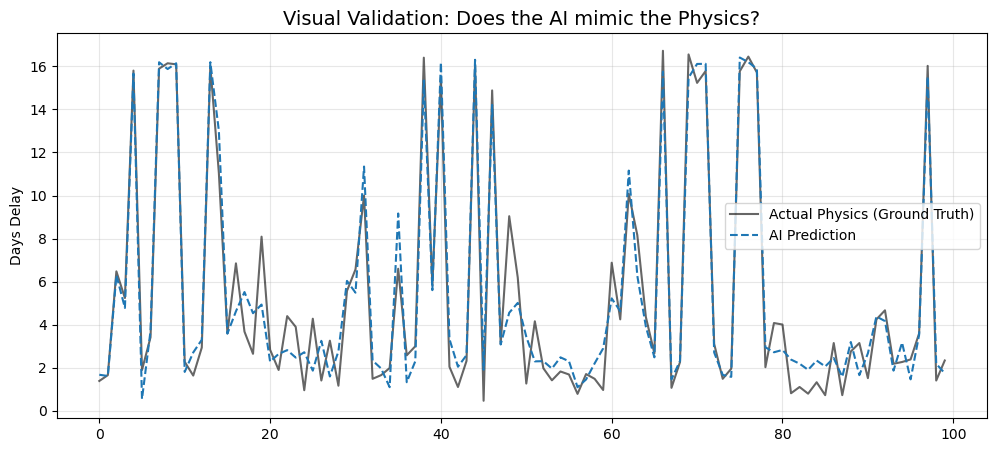

In [55]:
# ==========================================
# 2. TRAIN XGBOOST MODEL
# ==========================================
MODEL_DIR = os.path.join(PROJECT_ROOT, 'models')
MODEL_PATH = os.path.join(MODEL_DIR, 'congestion_model.pkl')
os.makedirs(MODEL_DIR, exist_ok=True)

model = xgb.XGBRegressor(
    n_estimators=1000,       # Max trees
    learning_rate=0.05,      # Slow learning for robustness
    max_depth=6,             # Depth of decision logic
    early_stopping_rounds=50, # Stop if validation score plateaus
    n_jobs=-1,
    random_state=42
)

print("\n⏳ Training Model (This acts as Knowledge Distillation)...")
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False  # Keep output clean
)

# SAVE MODEL
joblib.dump(model, MODEL_PATH)
print(f"✅ Model Saved to '{MODEL_PATH}'")

# ==========================================
# 3. EVALUATE PERFORMANCE
# ==========================================
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\n" + "="*30)
print(f"🏆 MODEL PERFORMANCE")
print(f"ERROR (MAE): ±{mae:.2f} Days")
print(f"ACCURACY (R²): {r2:.1%} variance explained")
print("="*30)

# Visual Validation
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual Physics (Ground Truth)', color='black', alpha=0.6)
plt.plot(predictions[:100], label='AI Prediction', color='#1f77b4', linestyle='--')
plt.title("Visual Validation: Does the AI mimic the Physics?", fontsize=14)
plt.ylabel("Days Delay")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [60]:
# ==========================================
# 4. INFERENCE ENGINE (SCENARIO GENERATOR)
# ==========================================
MODEL_PATH = os.path.join(PROJECT_ROOT, 'models', 'congestion_model.pkl')

# Reload Model (Simulating Production Environment)
loaded_model = joblib.load(MODEL_PATH)

def generate_bridge_curve(start_val, end_val, num_days, scenario_type='linear', last_known_bdi=None):
    """Generates synthetic market trajectory."""
    if num_days <= 0: return np.array([end_val])
    
    if scenario_type == 'linear':
        return np.linspace(start_val, end_val, num_days)
    
    elif scenario_type == 'spike': # Late Surge (Low Inertia)
        split_idx = int(num_days * 0.8)
        part1 = np.full(split_idx, start_val) 
        part2 = np.linspace(start_val, end_val, num_days - split_idx)
        return np.concatenate([part1, part2])
    
    elif scenario_type == 'crash': # Early Shift (High Inertia)
        split_idx = int(num_days * 0.2)
        part1 = np.linspace(start_val, end_val, split_idx)
        part2 = np.full(num_days - split_idx, end_val)
        return np.concatenate([part1, part2])
    
    elif scenario_type == 'stable': # Boring Market
        base = np.linspace(start_val, end_val, num_days)
        noise = np.random.normal(0, 20, num_days)
        return base + noise
    
    elif scenario_type == 'constant': # Constant BDI (use last_known_bdi)
        if last_known_bdi is not None:
            return np.full(num_days, last_known_bdi)
        else:
            return np.full(num_days, start_val)
    
    return np.linspace(start_val, end_val, num_days)

In [ ]:
# ==========================================
# UPDATED PREDICTION FUNCTION
# ==========================================
def predict_congestion(target_date, target_bdi, port_name, scenario_type, weather_profile=None):
    """
    Predicts congestion with optional Weather Override.
    """
    # 1. HANDLE WEATHER LOGIC
    # If user didn't provide weather, fetch the default for that month
    if weather_profile is None:
        month = pd.to_datetime(target_date).month
        weather_profile = get_climate(port_name, month)
        weather_source = "Historical Avg"
    else:
        weather_source = "User Scenario"

    # ... [Rest of Logic: Load History, Bridge, etc.] ...
    
    # (Copying the logic from previous step for completeness)
    df_history = df_train[['Date', 'BDI']].sort_values('Date').drop_duplicates('Date')
    last_known_date = df_history['Date'].max()
    last_known_bdi = df_history.iloc[-1]['BDI']
    
    target_date_obj = pd.to_datetime(target_date)
    days_gap = (target_date_obj - last_known_date).days
    
    if scenario_type == 'constant': target_bdi = last_known_bdi 
    
    if days_gap > 0:
        bridge_vals = generate_bridge_curve(last_known_bdi, target_bdi, days_gap, scenario_type)
        bridge_dates = pd.date_range(start=last_known_date + pd.Timedelta(days=1), end=target_date_obj)
        df_bridge = pd.DataFrame({'Date': bridge_dates, 'BDI': bridge_vals})
        df_full = pd.concat([df_history, df_bridge])
    else:
        df_full = df_history

    df_full['BDI_Inertia'] = df_full['BDI'].rolling(window=45, min_periods=1).mean()
    final_inertia = df_full.iloc[-1]['BDI_Inertia']
    
    # Prepare Input
    input_data = pd.DataFrame([{
        'BDI': target_bdi,
        'BDI_Inertia': final_inertia,
        'Rain_Forecast': weather_profile['rain'],
        'Wind_Forecast': weather_profile['wind'],
        'Fog_Risk': weather_profile['fog'],
        'Month': target_date_obj.month
    }])
    
    for col in features:
        if 'Port_' in col:
            input_data[col] = 1 if col == f"Port_{port_name.upper()}" else 0
    input_data = input_data[features]
    
    pred_delay = loaded_model.predict(input_data)[0]
    
    return {
        'Scenario': scenario_type.upper(),
        'Weather_Mode': weather_source, # Tell the user where weather came from
        'Weather_Used': weather_profile,
        'End_BDI': target_bdi,
        'Inertia': round(final_inertia, 1),
        'Delay': round(pred_delay, 2),
        'Timeline': df_bridge if days_gap > 0 else None
    }

🎯 USER REQUEST: Target BDI 4000 | Port: QINGDAO
Note: 'Constant' scenario will ignore the 4000 target and maintain history.

RESULTS:
1. SPIKE (Late Surge)  -> End BDI: 4000 -> Inertia: 2662.4 -> DELAY: 5.900000095367432d
2. LINEAR (Steady)     -> End BDI: 4000 -> Inertia: 3663.3 -> DELAY: 6.340000152587891d
3. CRASH (Early Shift) -> End BDI: 4000 -> Inertia: 4000.0 -> DELAY: 6.559999942779541d
4. CONSTANT (Flat)     -> End BDI: 2148.0 -> Inertia: 2148.0 -> DELAY: 4.550000190734863d


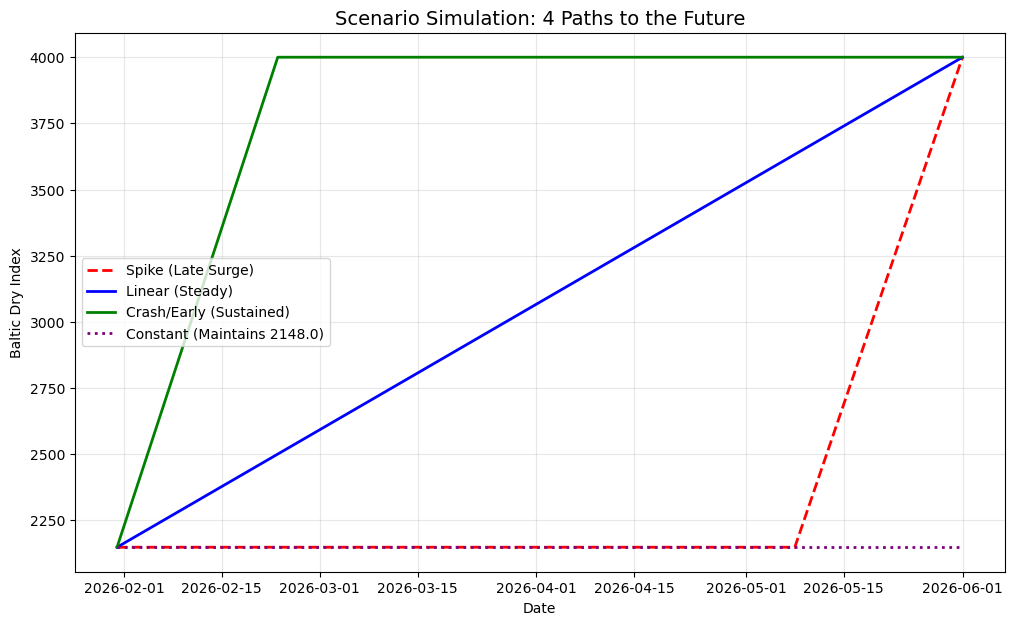

In [63]:
# ==========================================
# 5. RUN DEMO COMPARISON
# ==========================================
target_bdi = 4000
target_date = '2026-06-01' # Future Date

print(f"🎯 USER REQUEST: Target BDI {target_bdi} | Port: QINGDAO")
print(f"Note: 'Constant' scenario will ignore the 4000 target and maintain history.")

# Run 4 Scenarios
res_spike = predict_congestion(target_date, target_bdi, 'QINGDAO', 'spike')
res_linear = predict_congestion(target_date, target_bdi, 'QINGDAO', 'linear')
res_crash = predict_congestion(target_date, target_bdi, 'QINGDAO', 'crash')
res_const = predict_congestion(target_date, target_bdi, 'QINGDAO', 'constant')

print(f"\nRESULTS:")
print(f"1. SPIKE (Late Surge)  -> End BDI: {res_spike['End_BDI']} -> Inertia: {res_spike['Inertia']} -> DELAY: {res_spike['Delay']}d")
print(f"2. LINEAR (Steady)     -> End BDI: {res_linear['End_BDI']} -> Inertia: {res_linear['Inertia']} -> DELAY: {res_linear['Delay']}d")
print(f"3. CRASH (Early Shift) -> End BDI: {res_crash['End_BDI']} -> Inertia: {res_crash['Inertia']} -> DELAY: {res_crash['Delay']}d")
print(f"4. CONSTANT (Flat)     -> End BDI: {res_const['End_BDI']} -> Inertia: {res_const['Inertia']} -> DELAY: {res_const['Delay']}d")

# Plot
plt.figure(figsize=(12, 7))

# Helper to plot only the bridge part (future)
def plot_timeline(res, color, label, style='-'):
    if res['Timeline'] is not None:
        plt.plot(res['Timeline']['Date'], res['Timeline']['BDI'], label=label, color=color, linestyle=style, linewidth=2)

plot_timeline(res_spike, 'red', 'Spike (Late Surge)', '--')
plot_timeline(res_linear, 'blue', 'Linear (Steady)', '-')
plot_timeline(res_crash, 'green', 'Crash/Early (Sustained)', '-')
plot_timeline(res_const, 'purple', f'Constant (Maintains {res_const["End_BDI"]})', ':')

plt.title(f"Scenario Simulation: 4 Paths to the Future", fontsize=14)
plt.ylabel("Baltic Dry Index")
plt.xlabel("Date")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()